In [1]:

import os

from config import BASE_DIR
from src.baselines.main import make_baselines_results

In [2]:
chunk_sizes = [25, 50, 75, 100, 125, 150]
ss = [0.05, 0.1, 0.15]
params = []
for chunk_size in chunk_sizes:
    for prct in ss:
        params.append((chunk_size, int(prct * chunk_size)))
print(params)

[(25, 1), (25, 2), (25, 3), (50, 2), (50, 5), (50, 7), (75, 3), (75, 7), (75, 11), (100, 5), (100, 10), (100, 15), (125, 6), (125, 12), (125, 18), (150, 7), (150, 15), (150, 22)]


In [3]:
from datetime import datetime
from tqdm.notebook import tqdm
from src.ETL.main_ETL import generate_data

ALL_EXP_BASE_DIR = f"{BASE_DIR}/experiments/chunk_size"
for chunk_size, max_overlap in tqdm(params):
    print(f"{datetime.now()} - {chunk_size=}, {max_overlap=}")

    exp_name = f"{chunk_size=}_{max_overlap=}"
    exp_dir = f"{ALL_EXP_BASE_DIR}/{exp_name}"

    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir, exist_ok=True)
        df_name = f"{exp_dir}/{exp_name}.csv"
        #creating_data
        tmp_df = generate_data(chunk_size, max_overlap, df_name)
        df_filtered_name = f"{exp_dir}/filtered_{exp_name}.csv"
        #making baselines
        make_baselines_results(data_path=df_filtered_name, processed_vectorizers_path=f"{exp_dir}/{exp_name}.pkl",
                               results_dir=exp_dir, train_frac=0.7, val_frac=0.1, tasks=["scroll", "composition"])



In [32]:
import os
import pandas as pd
import re

ALL_EXP_BASE_DIR = f"{BASE_DIR}/experiments/chunk_size"

book_supervised = []
book_unsupervised = []
composition_supervised = []
composition_unsupervised = []
for exp in os.listdir(ALL_EXP_BASE_DIR):
    # if exp == 'chunk_size=125_max_overlap=12' or exp == 'chunk_size=125_max_overlap=6':
    #     continue
    base = f"{ALL_EXP_BASE_DIR}/{exp}"
    tmp_df_book_supervised = pd.read_csv(f"{base}/book_supervised.csv")
    tmp_df_book_supervised['chunk_size'] = re.findall(r"chunk_size=(\d+)", exp)[0]
    tmp_df_book_supervised['max_overlap'] = re.findall(r"max_overlap=(\d+)", exp)[0]
    book_supervised.append(tmp_df_book_supervised)

    tmp_df_book_unsupervised = pd.read_csv(f"{base}/book_unsupervised.csv")
    tmp_df_book_unsupervised['chunk_size'] = re.findall(r"chunk_size=(\d+)", exp)[0]
    tmp_df_book_unsupervised['max_overlap'] = re.findall(r"max_overlap=(\d+)", exp)[0]
    book_unsupervised.append(tmp_df_book_unsupervised)

    tmp_df_composition_supervised = pd.read_csv(f"{base}/composition_supervised.csv")
    tmp_df_composition_supervised['chunk_size'] = re.findall(r"chunk_size=(\d+)", exp)[0]
    tmp_df_composition_supervised['max_overlap'] = re.findall(r"max_overlap=(\d+)", exp)[0]
    composition_supervised.append(tmp_df_composition_supervised)

    tmp_df_composition_unsupervised = pd.read_csv(f"{base}/composition_unsupervised.csv")
    tmp_df_composition_unsupervised['chunk_size'] = re.findall(r"chunk_size=(\d+)", exp)[0]
    tmp_df_composition_unsupervised['max_overlap'] = re.findall(r"max_overlap=(\d+)", exp)[0]

    composition_unsupervised.append(tmp_df_composition_unsupervised)
df_book_supervised = pd.concat(book_supervised)
df_book_unsupervised = pd.concat(book_unsupervised)
df_composition_supervised = pd.concat(composition_supervised)
df_composition_unsupervised = pd.concat(composition_unsupervised)




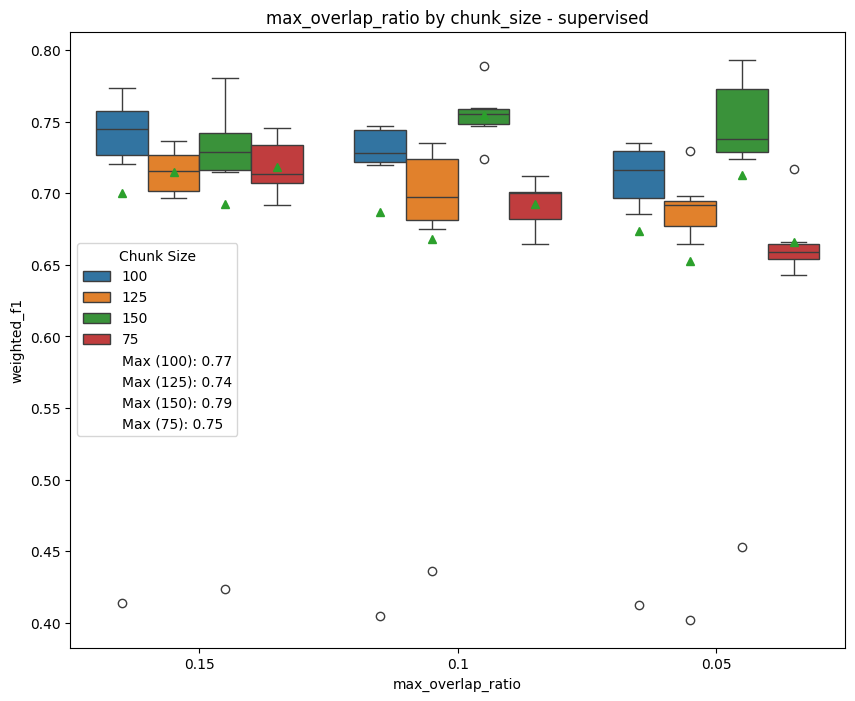

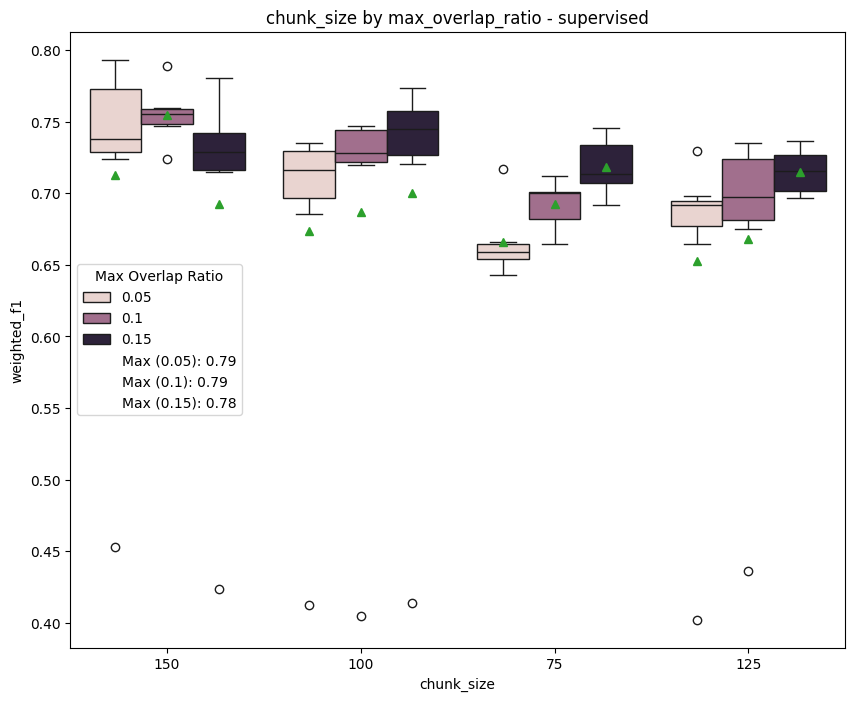

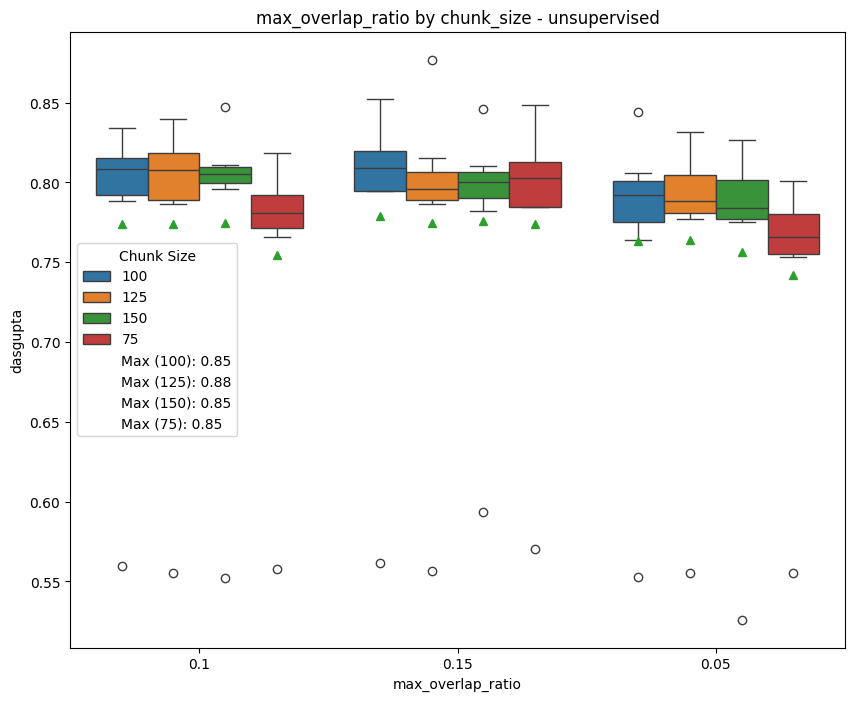

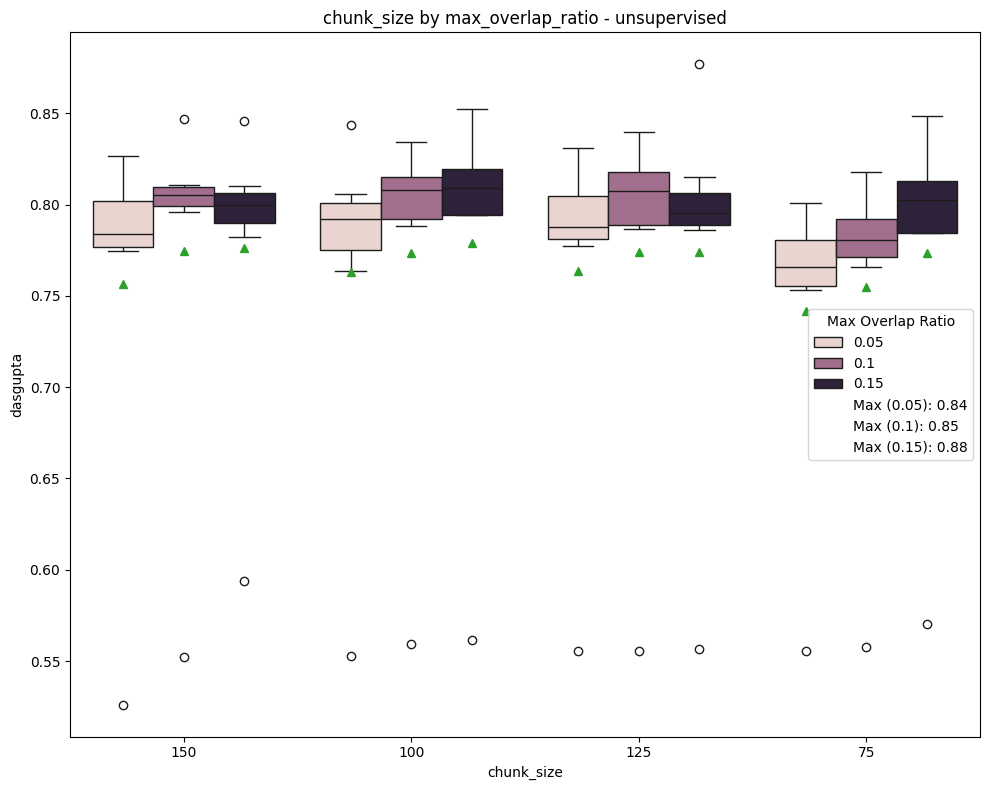

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results = {"book_supervised": df_book_supervised,
           "book_unsupervised": df_book_unsupervised,
           "composition_supervised": df_composition_supervised,
           "composition_unsupervised": df_composition_unsupervised
           }

results = {"supervised": pd.concat([df_book_supervised, df_composition_supervised]),
           "unsupervised": pd.concat([df_book_unsupervised, df_composition_unsupervised]),
           }

possible_max_overlap = np.array([0.05, 0.1, 0.15])


def fix_approx_error(df):
    mask = (df["max_overlap"] == "3") & (df["chunk_size"] == "25")
    df.loc[mask, "max_overlap_ratio"] = 0.15
    return df


for name, df_res in results.items():
    if "unsupervised" in name:
        met = "dasgupta"
        vec_type = "vectorizer_type"
    else:
        met = "weighted_f1"
        vec_type = "vectorizer"

    if df_res["max_overlap"].dtype == "object":
        # Calculate the actual overlap ratio
        overlap_ratio = df_res["max_overlap"].astype(int) / df_res["chunk_size"].astype(int)

        # Find the closest value in possible_max_overlap
        idx = np.searchsorted(possible_max_overlap, overlap_ratio, side="left")
        idx = np.clip(idx, 0, len(possible_max_overlap) - 1)
        left_distance = np.abs(overlap_ratio - possible_max_overlap[np.maximum(idx - 1, 0)])
        right_distance = np.abs(overlap_ratio - possible_max_overlap[np.minimum(idx, len(possible_max_overlap) - 1)])
        idx = np.where(left_distance < right_distance, np.maximum(idx - 1, 0), idx)

        # Assign the approximated value
        df_res["max_overlap_ratio"] = possible_max_overlap[idx]

        # Fix the specific case
        df_res = fix_approx_error(df_res)

    df_res = df_res[~df_res["chunk_size"].isin(["25", "50"])]
    df_res = df_res.groupby(["chunk_size", "max_overlap_ratio", vec_type])[met].max().reset_index()
    df_res = df_res[df_res[met] > 0.4]
    # Sort by median values for max_overlap_ratio plot
    median_values = df_res.groupby('max_overlap_ratio')[met].median().sort_values(ascending=False)
    order_max_overlap = median_values.index.tolist()

    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(data=df_res, x="max_overlap_ratio", y=met, hue="chunk_size", showmeans=True, showfliers=True,
                     order=order_max_overlap)
    plt.title(f"max_overlap_ratio by chunk_size - {name}")

    # Add maximum values to the legend
    handles, labels = ax.get_legend_handles_labels()
    for i, chunk_size in enumerate(df_res['chunk_size'].unique()):
        max_value = df_res[df_res['chunk_size'] == chunk_size][met].max()
        handles.append(plt.Line2D([0], [0], color='w', label=f'Max ({chunk_size}): {max_value:.2f}'))
    ax.legend(handles=handles, title='Chunk Size')

    # Sort by median values for chunk_size plot
    median_values = df_res.groupby('chunk_size')[met].median().sort_values(ascending=False)
    order_chunk_size = median_values.index.tolist()

    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(data=df_res, x="chunk_size", y=met, hue="max_overlap_ratio", showmeans=True, showfliers=True,
                     order=order_chunk_size)
    plt.title(f"chunk_size by max_overlap_ratio - {name}")

    # Add maximum values to the legend
    handles, labels = ax.get_legend_handles_labels()
    for i, overlap_ratio in enumerate(df_res['max_overlap_ratio'].unique()):
        max_value = df_res[df_res['max_overlap_ratio'] == overlap_ratio][met].max()
        handles.append(plt.Line2D([0], [0], color='w', label=f'Max ({overlap_ratio}): {max_value:.2f}'))
    ax.legend(handles=handles, title='Max Overlap Ratio')

plt.tight_layout()
plt.show()

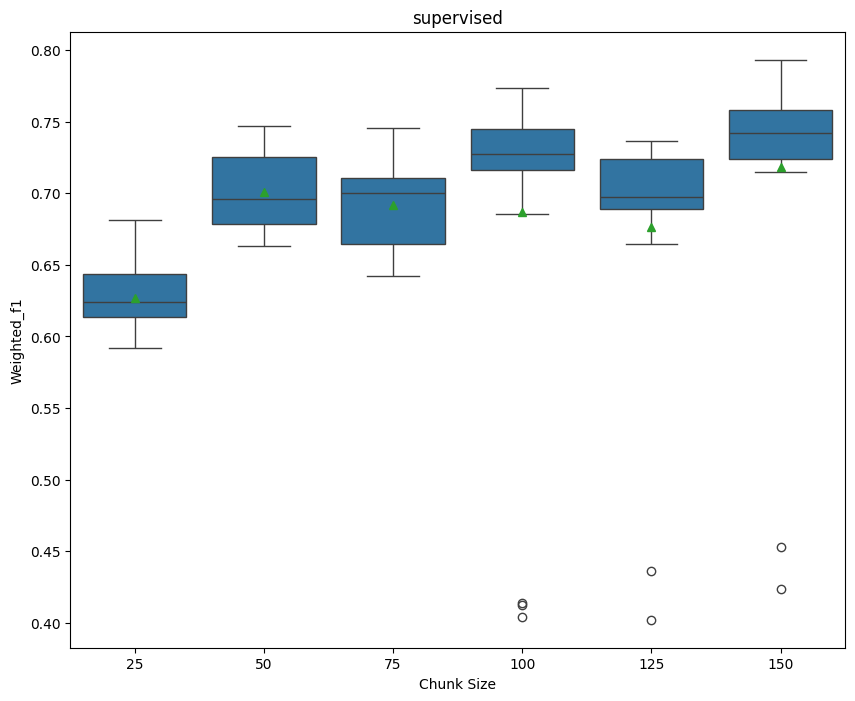

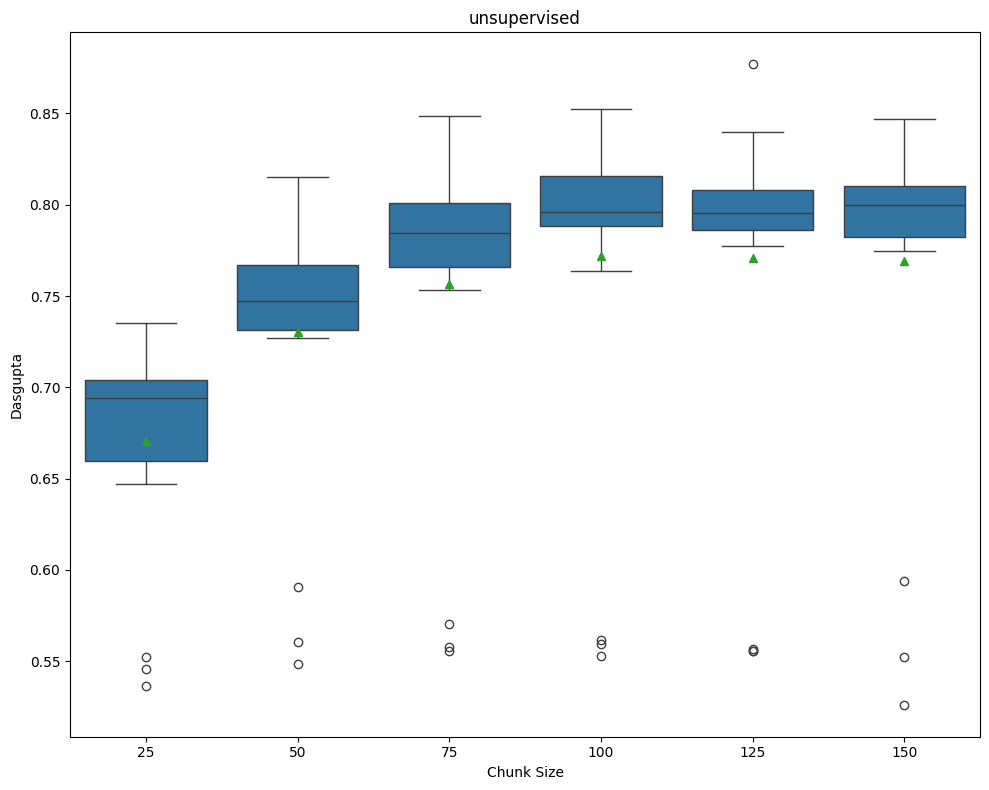

In [42]:
for name, df_res in results.items():
    plt.figure(figsize=(10, 8))
    if "unsupervised" in name:
        met = "dasgupta"
        vec_type = "vectorizer_type"
    else:
        met = "weighted_f1"
        vec_type = "vectorizer"
    df_res = df_res.groupby(["chunk_size", "max_overlap_ratio", vec_type])[met].max().reset_index()

    df_res = df_res[df_res[met] > 0.4]

    # Convert chunk_size to integer and sort
    df_res["chunk_size"] = df_res["chunk_size"].astype(int)
    order_chunk_size = sorted(df_res["chunk_size"].unique())

    sns.boxplot(data=df_res, x="chunk_size", y=met, showmeans=True, order=order_chunk_size)
    plt.title(name)
    plt.xlabel("Chunk Size")
    plt.ylabel(met.capitalize())

plt.tight_layout()
plt.show()

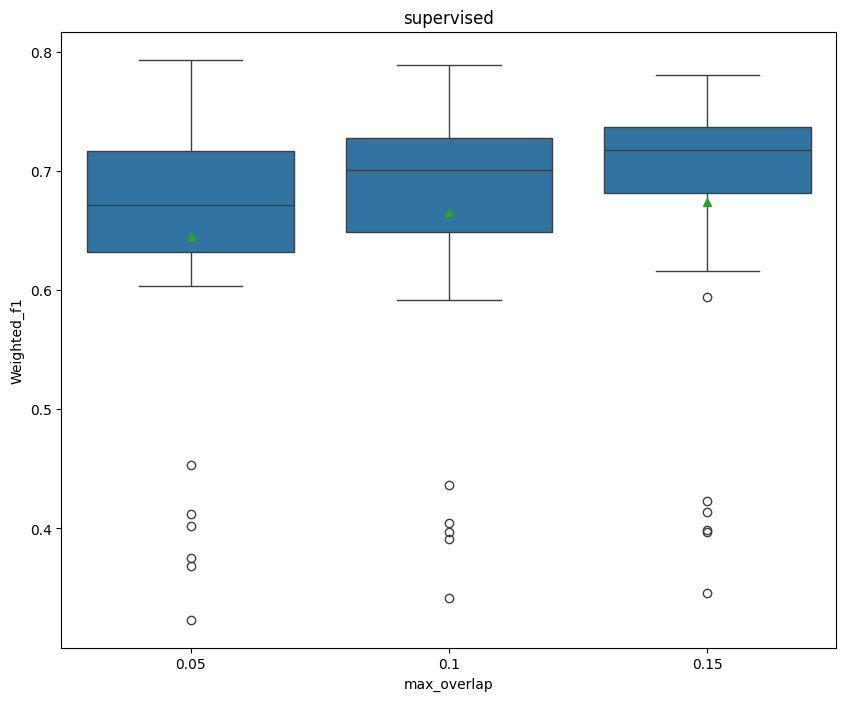

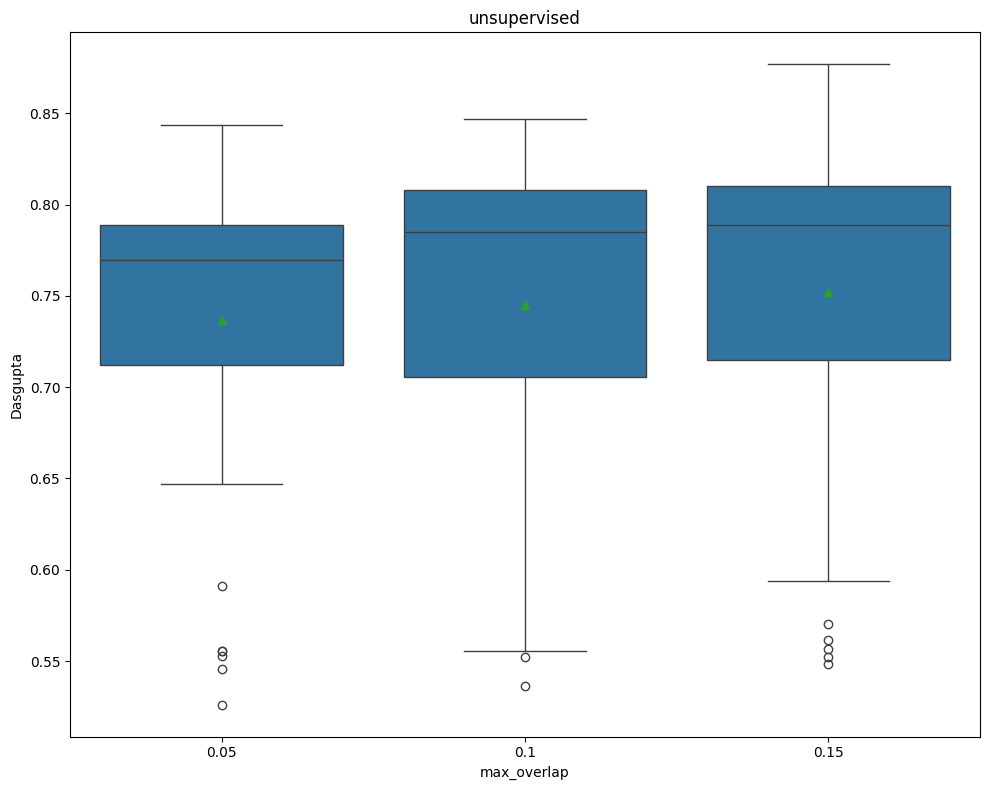

In [43]:
for name, df_res in results.items():
    plt.figure(figsize=(10, 8))
    if "unsupervised" in name:
        met = "dasgupta"
        vec_type = "vectorizer_type"
    else:
        met = "weighted_f1"
        vec_type = "vectorizer"

    # if df_res["max_overlap_ratio"].dtype == "object":
    #     df_res["max_overlap"] = df_res["max_overlap"].astype(int)/df_res["chunk_size"].astype(int)

    # Convert chunk_size to integer and sort
    # df_res["max_overlap"] = df_res["max_overlap"].astype(float)
    # order_chunk_size = sorted(df_res["max_overlap"].unique())
    # df_res["max_overlap"] = df_res["max_overlap"].astype(str)
    df_res = df_res.groupby(["chunk_size", "max_overlap_ratio", vec_type])[met].max().reset_index()

    df_res = df_res[df_res[met] > 0.3]
    sns.boxplot(data=df_res, x="max_overlap_ratio", y=met, showmeans=True)
    plt.title(name)
    plt.xlabel("max_overlap")
    plt.ylabel(met.capitalize())

plt.tight_layout()
plt.show()

In [16]:
df_res

,model,accuracy,micro_precision,micro_recall,micro_f1,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,vectorizer,chunk_size,max_overlap,max_overlap_ratio
0,LinearSVC,0.507282,0.507282,0.507282,0.507282,0.428301,0.374033,0.376141,0.472124,0.507282,0.462689,tfidf,100,0.0,0.05
1,LogisticRegression,0.495146,0.495146,0.495146,0.495146,0.355732,0.332498,0.316140,0.439903,0.495146,0.440141,dicta-il/dictabert,100,0.0,0.05
2,LogisticRegression,0.492718,0.492718,0.492718,0.492718,0.395829,0.333997,0.333905,0.464662,0.492718,0.449715,yonatanlou/BEREL-finetuned-DSS-maskedLM,100,0.0,0.05
3,LogisticRegression,0.480583,0.480583,0.480583,0.480583,0.363682,0.332147,0.324996,0.439871,0.480583,0.434169,trigram,100,0.0,0.05
4,MLPClassifier,0.480583,0.480583,0.480583,0.480583,0.377846,0.345684,0.341810,0.448077,0.480583,0.446518,dicta-il/dictabert,100,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,KNeighborsClassifier,0.446009,0.446009,0.446009,0.446009,0.537348,0.404263,0.430444,0.606439,0.446009,0.484604,trigram,125,0.0,0.15
24,LogisticRegression,0.441315,0.441315,0.441315,0.441315,0.301378,0.307952,0.295035,0.383720,0.441315,0.397278,starr,125,0.0,0.15
25,KNeighborsClassifier,0.342723,0.342723,0.342723,0.342723,0.238639,0.248899,0.237500,0.306883,0.342723,0.315703,starr,125,0.0,0.15
26,MLPClassifier,0.276995,0.276995,0.276995,0.276995,0.201846,0.167418,0.147207,0.271826,0.276995,0.224970,starr,125,0.0,0.15


In [18]:
import pandas as pd

df = pd.read_csv(
    "/Users/yonatanlou/dev/QumranNLP/experiments/chunk_size/chunk_size=100_max_overlap=10/filtered_chunk_size=100_max_overlap=10.csv")
df_grouped = df.groupby("book")["text"].apply(" ".join).reset_index()
df_grouped["number_of_words"] = df_grouped["text"].str.split().apply(len)
df_grouped.sort_values(by="number_of_words")

,book,text,number_of_words
45,4Q300,ראות ם מעשי ארץ מעשה אף ועבודת ת החרטמים מלמד...,301
27,4Q225,ל מעוון הזנות אשר ם הואה אתכל מצרים ויכא אותם...,304
91,4Q521,ם ים ים ושמעתם ופעלת ימה עברתם וליראה א רבו צ...,307
90,4Q513,השקל גרה עשרים בשקל הקודש מחצית השקל מעה שתים...,307
35,4Q261,את בריתו ולפקוד את כל חוקו אשר צוה לעשות ועל פ...,308
...,...,...,...
9,1QS,ל שים לחיו ספר סרך היחד לדרוש אל בכול לב ובכול...,3995
95,CD,ועתה שמעו כל יודעי צדק ובינו במעשי אל כי ריב ל...,4292
8,1QM,למשכיל ספר סרך המלחמה ראשית משלוח יד בני אור ל...,4389
7,1QHa,נפלואתיכה אין פה ותוצא לעולמי ישמיעו בהמון רנ...,8072


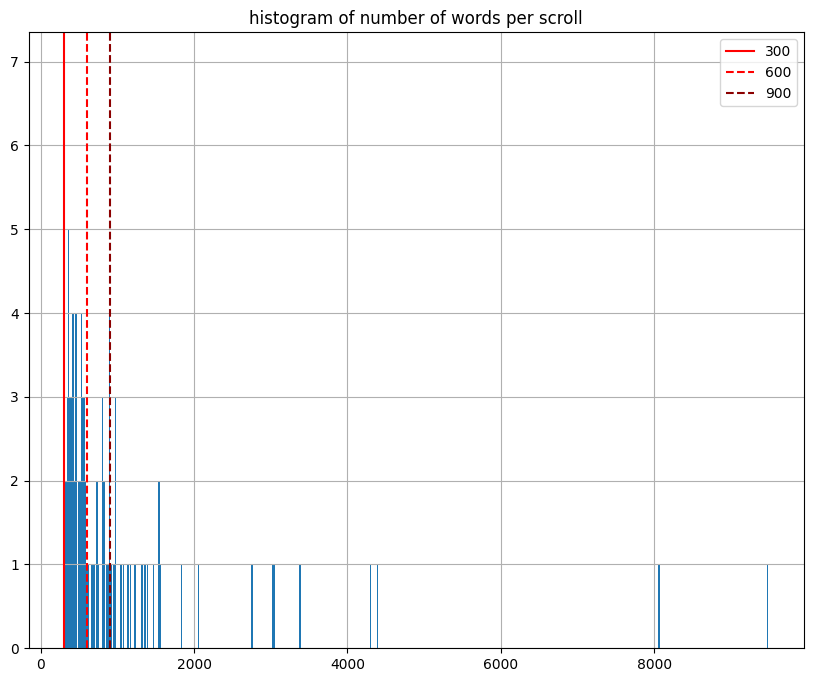

In [19]:
import matplotlib.pyplot as plt

df_grouped["number_of_words"].hist(bins=500, figsize=(10, 8))
plt.axvline(300, color="r", label="300")
plt.axvline(600, color="r", linestyle="--", label="600")
plt.axvline(900, color="darkred", linestyle="--", label="900")
plt.title("histogram of number of words per scroll")
plt.legend()

In [22]:
df_grouped[df_grouped["number_of_words"] < 600].shape

(49, 3)

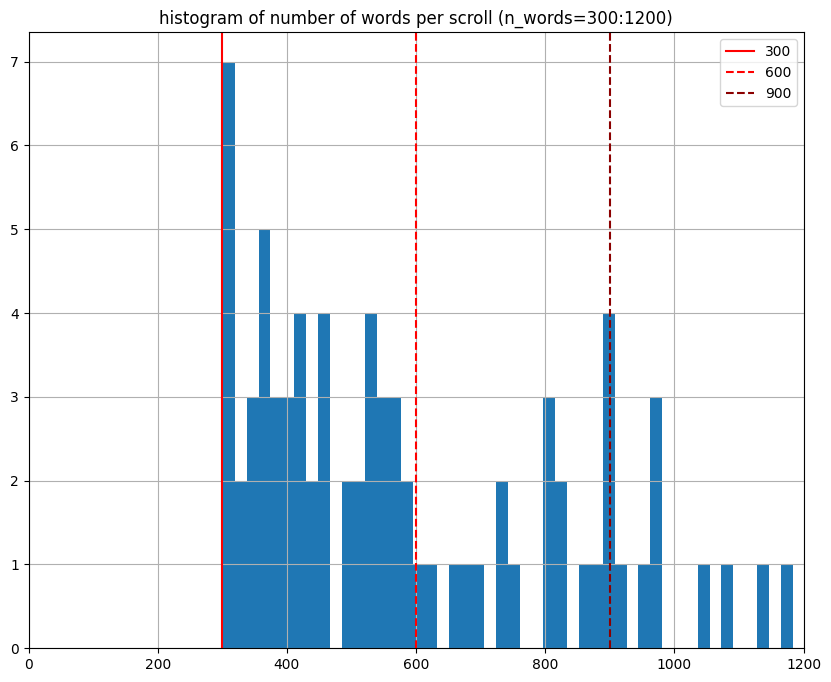

In [20]:
import matplotlib.pyplot as plt

df_grouped["number_of_words"].hist(bins=500, figsize=(10, 8))
plt.axvline(300, color="r", label="300")
plt.axvline(600, color="r", linestyle="--", label="600")
plt.axvline(900, color="darkred", linestyle="--", label="900")
plt.xlim(0, 1200)
plt.title("histogram of number of words per scroll (n_words=300:1200)")
plt.legend()

In [16]:
import pandas as pd

df = pd.read_csv(
    "/Users/yonatanlou/dev/QumranNLP/experiments/chunk_size/chunk_size=100_max_overlap=10/filtered_chunk_size=100_max_overlap=10.csv")
df_grouped = df.groupby("composition")["text"].apply(" ".join).reset_index()
df_grouped["number_of_words"] = df_grouped["text"].str.split().apply(len)
df_grouped.drop("text", axis=1).sort_values(by="number_of_words")

,composition,number_of_words
4,Barkhi_Nafshi,360
5,Berakhot,527
21,the_rule_of_the_congregation,565
20,the_rule_of_the_blessings,565
14,Pseudo_Jeremiah,687
8,Catena_Florilegium,1181
2,4QMMT,1287
9,Collections_of_psalms,1323
12,Mysteries,1346
16,Songs_of_Maskil,1539


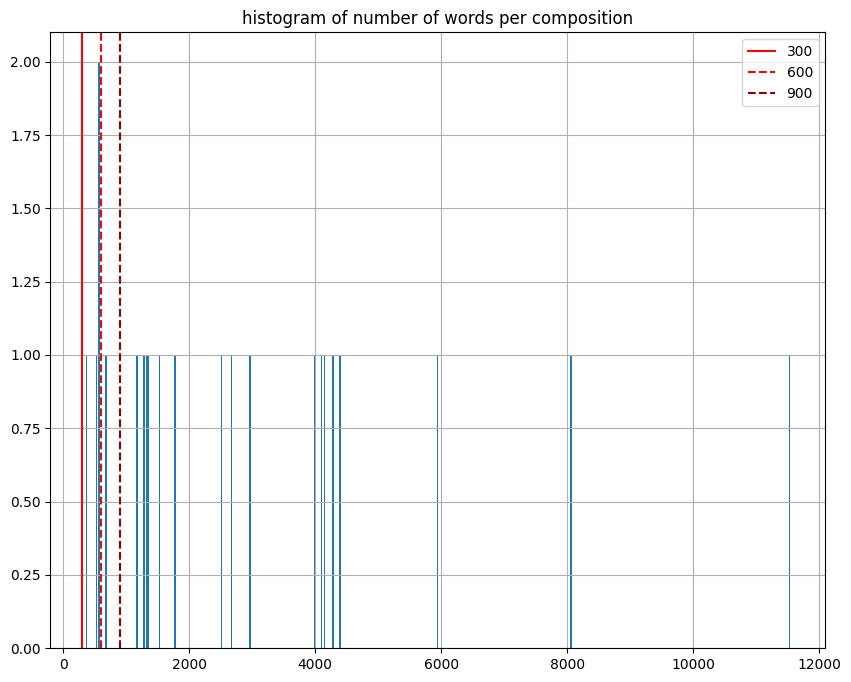

In [14]:
import matplotlib.pyplot as plt

df_grouped["number_of_words"].hist(bins=500, figsize=(10, 8))
plt.axvline(300, color="r", label="300")
plt.axvline(600, color="r", linestyle="--", label="600")
plt.axvline(900, color="darkred", linestyle="--", label="900")
plt.title("histogram of number of words per composition")
plt.legend()

In [6]:
import pandas as pd
df = pd.read_csv("/Users/yonatanlou/dev/QumranNLP/experiments/pre_processing/WEAK_MFW_20/filtered_WEAK_MFW_20.csv")
df

,book,sentence_path,text_lex,text,n_words_lex,n_words,construct to absolute nouns ratio,construct nouns and adjectives percentage,noun to verb ratio,definite_article_percentage,...,aCr percentage,oM percentage,kya percentage,all conjunctions percentage,non-finite to finite verbs ratio,passive verb forms percentage,total word count,bib,section,composition
0,CD,CD:1:1-1:14,שמע כל ידע צדק בין מעשה אל ריב ל כל בשר משפט ע...,שמעו כל יודעי צדק בינו מעשי אל ריב לו כל בשר מ...,105.0,105.0,0.608696,0.225806,1.800000,0.0,...,0.0,0.0,0.0,0.0,0.562500,0.000000,62.0,nonbib,sectarian_texts,CD
1,CD,CD:1:14-2:5,סרר ישראל עמד איש לצון נטף ישראל מים כזב תעה ת...,סרר ישראל עמוד איש לצון הטיף ישראל מימי כזב ית...,108.0,108.0,0.484848,0.288136,1.700000,0.0,...,0.0,0.0,0.0,0.0,0.666667,0.000000,59.0,nonbib,sectarian_texts,CD
2,CD,CD:2:5-2:17,כפר שוב פשע כח גבורה חמה גדול להב אש יד כל מלא...,כפר שבי פשע כוח גבורה חמה גדולה להבי אש ידי כל...,109.0,109.0,0.827586,0.393939,1.766667,0.0,...,0.0,0.0,0.0,0.0,0.875000,4.545455,66.0,nonbib,sectarian_texts,CD
3,CD,CD:2:17-3:9,תעה ב גבור חיל כשל ב פנה הלך שררות לב נפל עד ע...,תעו בם גבורי חיל נכשלו בם פנים לכתם שרירות לבם...,119.0,119.0,1.058824,0.263889,1.166667,0.0,...,0.0,0.0,0.0,0.0,0.161290,13.888889,72.0,nonbib,sectarian_texts,CD
4,CD,CD:3:9-4:1,עדה בן ב אבד מלך ב כרת גבור ב אבד ארץ ב שמם ב ...,עדתם בניהם בו אבדו מלכיהם בו נכרתו גיבוריהם בו...,121.0,121.0,0.950000,0.260274,1.393939,0.0,...,0.0,0.0,0.0,0.0,0.375000,6.849315,73.0,nonbib,sectarian_texts,CD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,11Q20,11Q20:12:17-13:2,עוף טמא יכל היה תוך מקדש עולם כל יום אני שכן ת...,עוף טמא יוכל היות תוך מקדשי עולם כול ימים אני ...,108.0,108.0,0.343750,0.166667,1.375000,0.0,...,0.0,0.0,0.0,0.0,1.000000,6.060606,66.0,nonbib,unknown,Temple Scroll
725,11Q20,11Q20:13:2-14:16,בוא צרע זוב איש היה ל מקרה לילה בוא רחוק כל דב...,באים מצורעים זבים אנשים יהיה להמה מקרה לילה בא...,115.0,115.0,0.470588,0.314815,1.428571,0.0,...,0.0,0.0,0.0,0.0,0.458333,5.555556,54.0,nonbib,unknown,Temple Scroll
726,11Q20,11Q20:14:16-15:2,כל מעשה עז משפט תורה זה עשה ל כל כלי חרש שבר ט...,כול מעשה עזים משפט תורה זואת תעשו להמה כול כלי...,125.0,125.0,0.500000,0.268657,1.583333,0.0,...,0.0,0.0,0.0,0.0,0.161290,4.477612,67.0,nonbib,unknown,Temple Scroll
727,11Q20,11Q20:15:2-16:4,ל הר זה טמא אני יהוה שכן תוך בן ישראל קדש היה ...,לכמה הר זה יטמאו אני יהוה שוכן תוך בני ישראל ק...,110.0,110.0,0.433333,0.194030,1.451613,0.0,...,0.0,0.0,0.0,0.0,0.409091,1.492537,67.0,nonbib,unknown,Temple Scroll
